In [1]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import *
from PixelGen.scvi_utils import plot_losses
from PixelGen.tests import test_convert_edgelist_to_protein_pair_colocalization

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator.statistics import clr_transformation
from pixelator.analysis.normalization import dsb_normalize


import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson
from torch.distributions import kl_divergence as kl

from PixelGen.modules import NormalVAE, NormalSCVI
from cytovi import CytoVI

print(torch.cuda.is_available())

%load_ext autoreload
%autoreload 2

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_use_gpu' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


True


Seed set to 0


Last run with scvi-tools version: 1.2.2.post2


In [2]:
DATA_DIR = Path('./PixelGen/datasets')


FILENAMES = [
    "Uropod_CD54_fixed.layout.dataset.pxl",
    "Uropod_CD54_fixed_RANTES_stimulated.layout.dataset.pxl",
    "Uropod_CD54_fixed_MCP1_stimulated.layout.dataset.pxl",
    "Uropod_control.layout.dataset.pxl",
    "Uropod_control_RANTES_stimulated.layout.dataset.pxl",
    "Uropod_control_MCP1_stimulated.layout.dataset.pxl",
]

SAMPLE_NAMES = [
    "imm_no_cytokine", 
    "imm_rantes",
    "imm_mcp1", 
    "sol_no_cytokine",
    "sol_rantes",
    "sol_mcp1"
]

# COMBINED_FILENAME = "combined_resting_data.pxl"

COMBINED_FILENAME = "uropod_combined.pxl"
COMBINED_PROCESSED_NAME = "uropod_combined_PROCESSED.pxl"

combined_path = DATA_DIR / COMBINED_FILENAME

# pg_data = pixelator.read(DATA_DIR / COMBINED_PROCESSED_NAME)
# adata = pg_data.adata

if os.path.exists(combined_path):
    pg_data = pixelator.read(combined_path)
else:
    
    baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/uropod-t-cells-v1.0-immunology-I"
    for filename in FILENAMES:
        !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} {baseurl}/{filename}

    datasets = [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
    pg_data = pixelator.simple_aggregate(
        SAMPLE_NAMES, datasets
    )
    pg_data.save(combined_path, force_overwrite=True)

In [3]:
adata = pg_data.adata.copy()
adata.raw = adata.copy()
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='proteins')
adata.layers['counts'] = adata.X.copy()

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


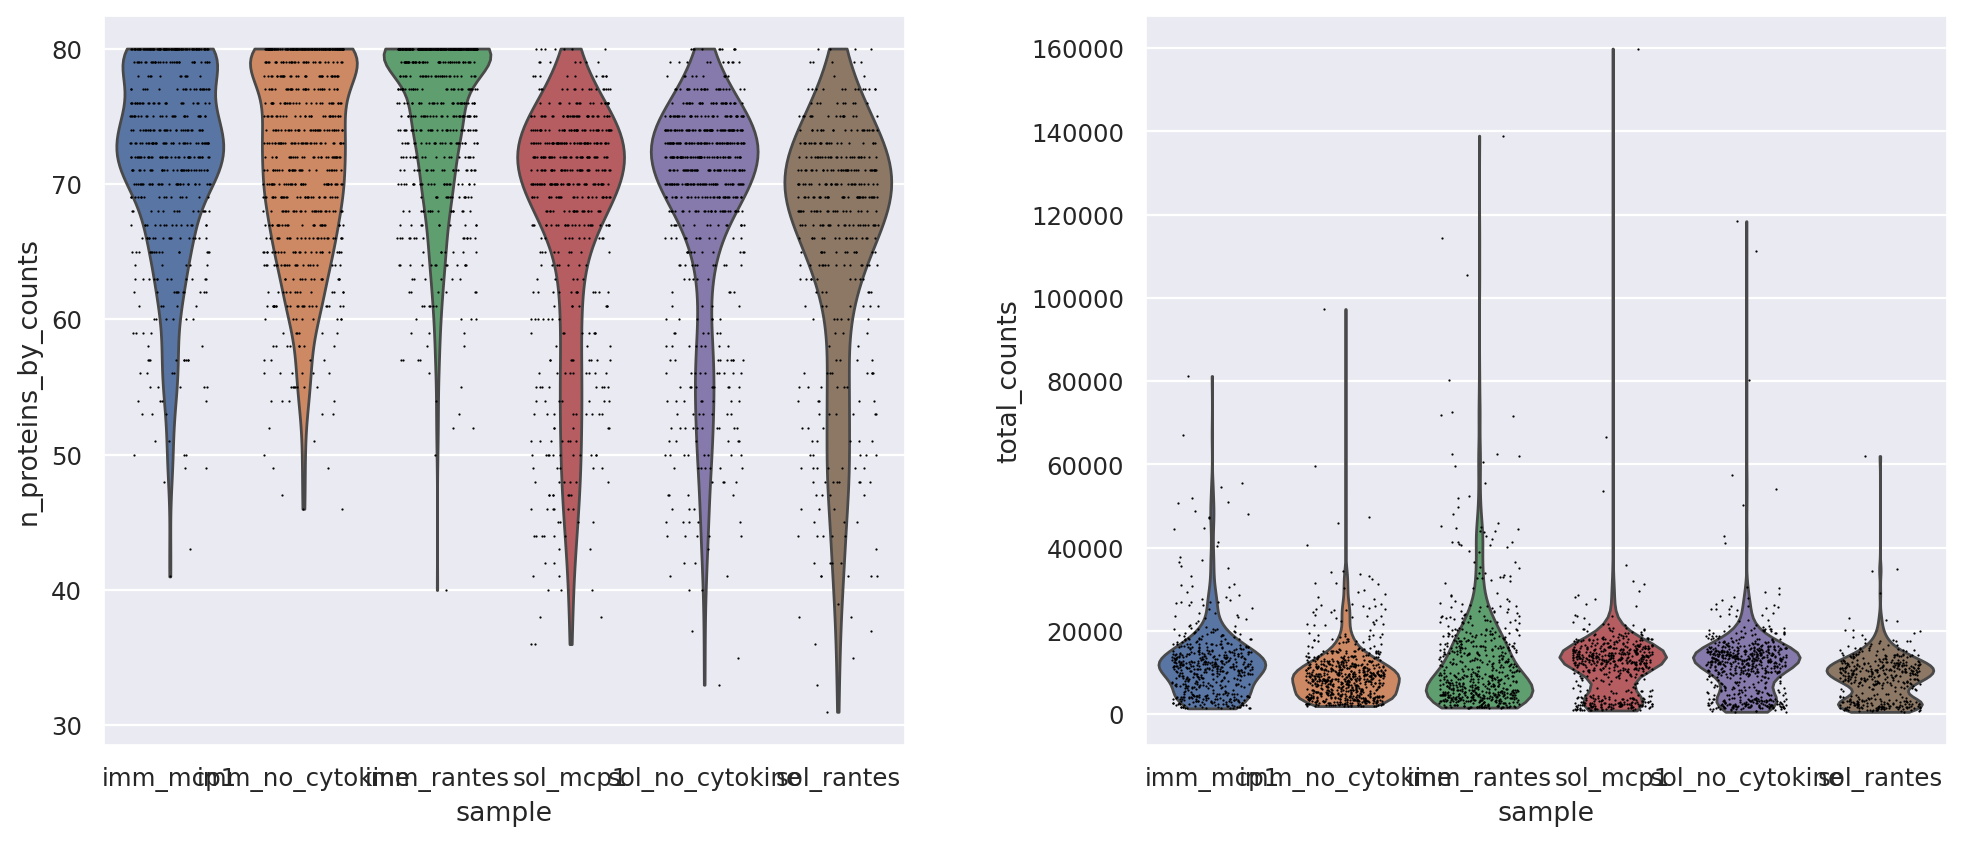

In [4]:
sc.pl.violin(
    adata,
    ["n_proteins_by_counts", "total_counts",],
    groupby='sample',
    jitter=0.3,
    multi_panel=True,
)

/tmp/ipykernel_1159976/3287934318.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/pixelator/plot/__init__.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


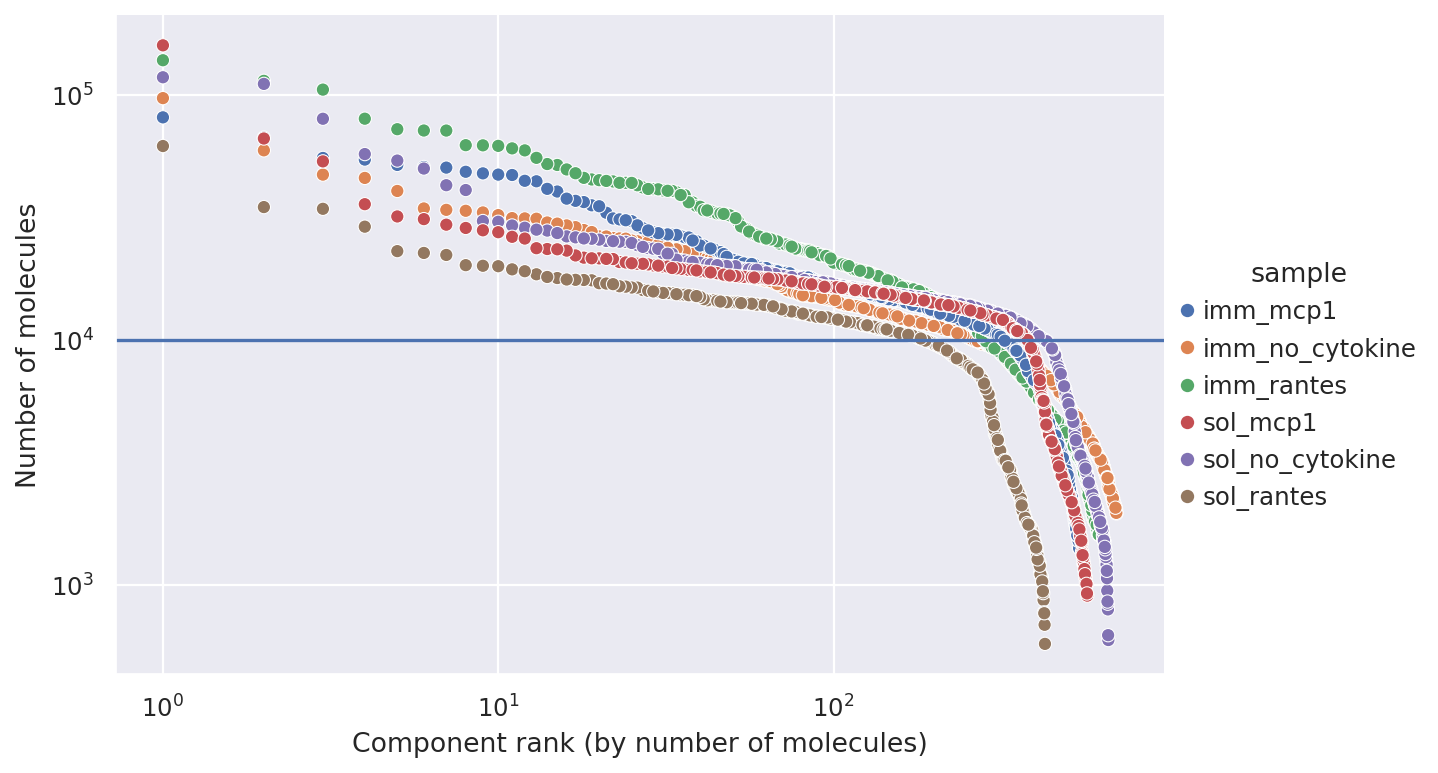

In [5]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig_intersection, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")
ax.axhline(y=10000)

/tmp/ipykernel_1159976/61645433.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/pixelator/plot/__init__.py:271: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(color_by).size().reset_index(name="n")


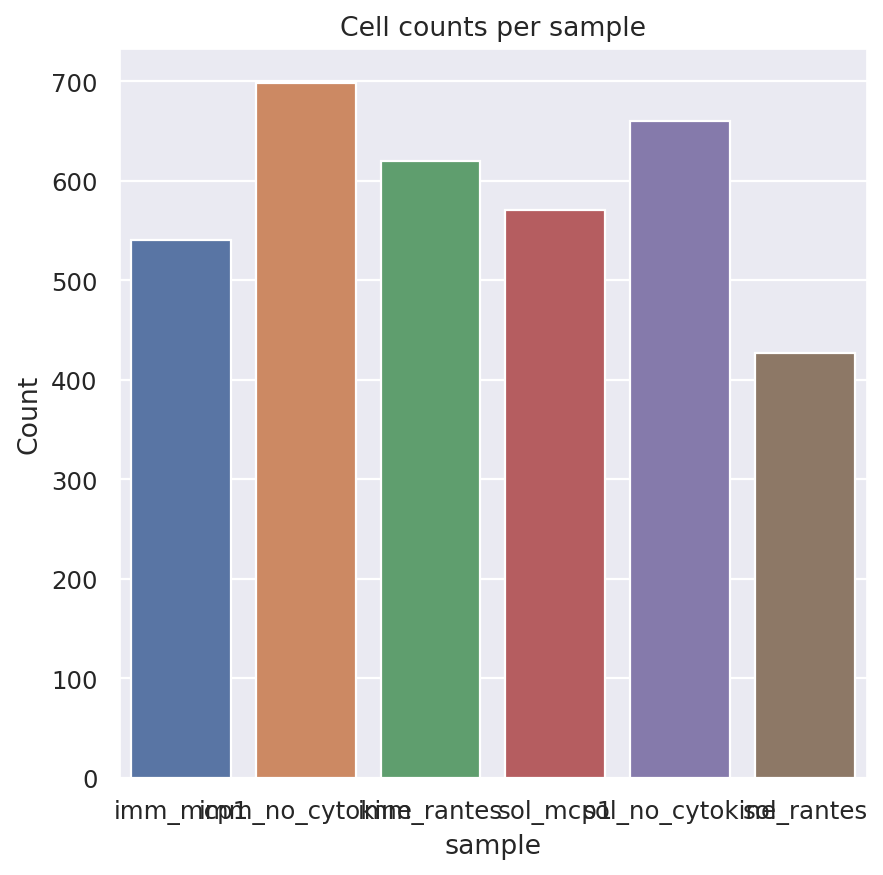

In [6]:
cells_per_sample_df = (
    adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
)

fig, ax = cell_count_plot(adata.obs, color_by="sample")

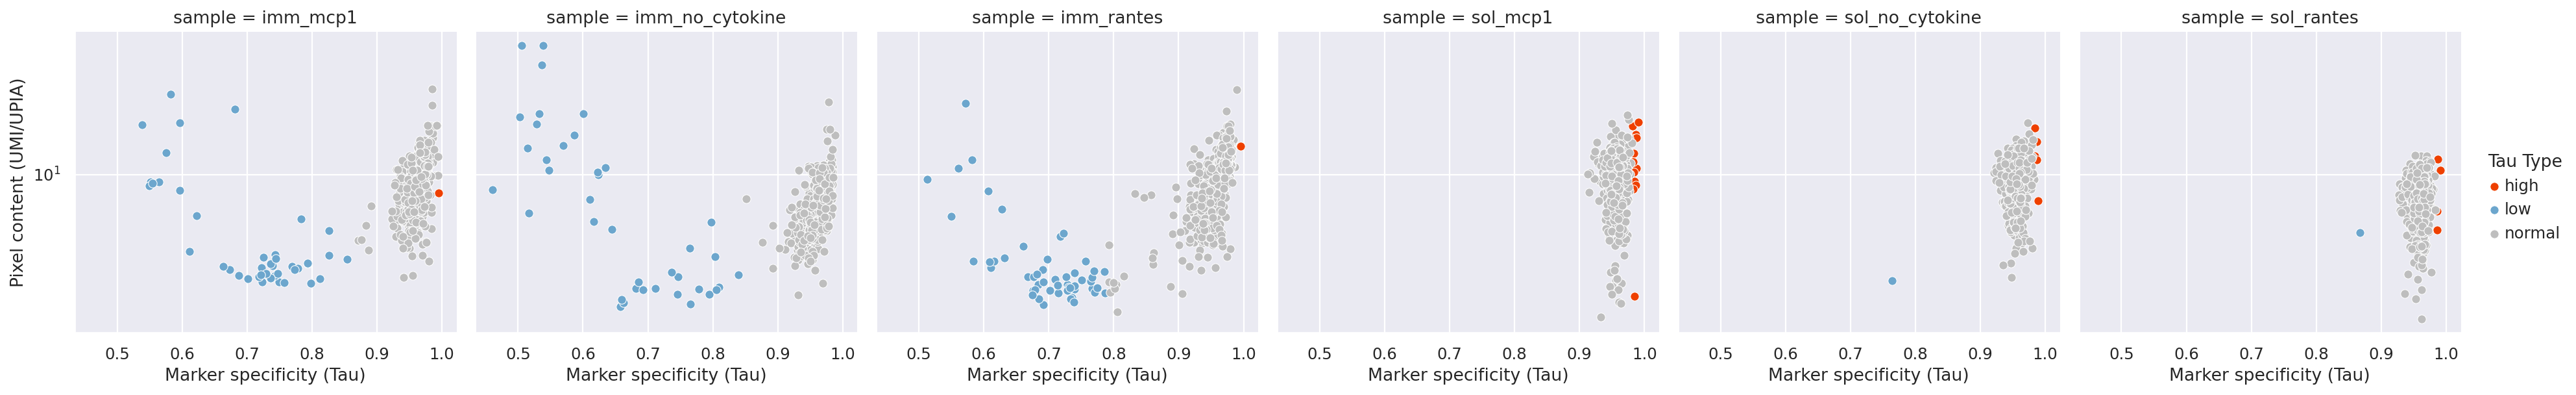

In [7]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

/tmp/ipykernel_1159976/839017279.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/pixelator/plot/__init__.py:271: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(color_by).size().reset_index(name="n")


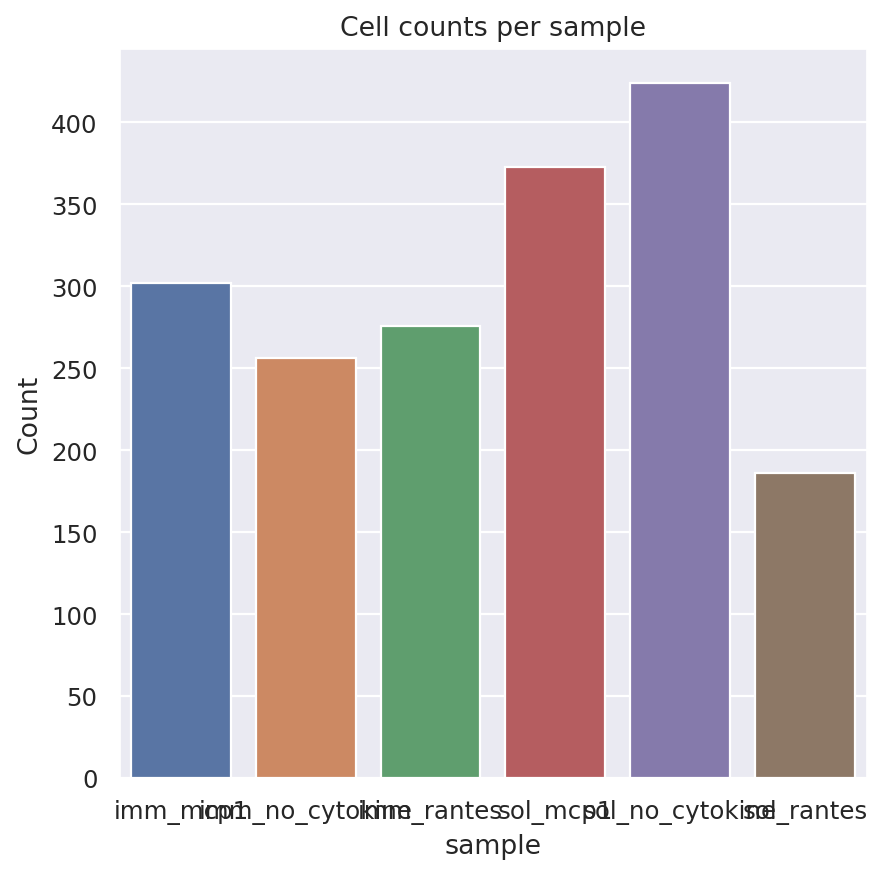

In [8]:
components = adata.obs[
    (adata.obs['tau_type'] == 'normal') & 
    (adata.obs['molecules'] > 10000)
].index
orig_adata = adata.copy()
adata = orig_adata[components, :]
cells_per_sample_df = (
    adata.obs.groupby("sample").size().to_frame(name="size").reset_index()
)

fig, ax = cell_count_plot(adata.obs, color_by="sample")

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[]

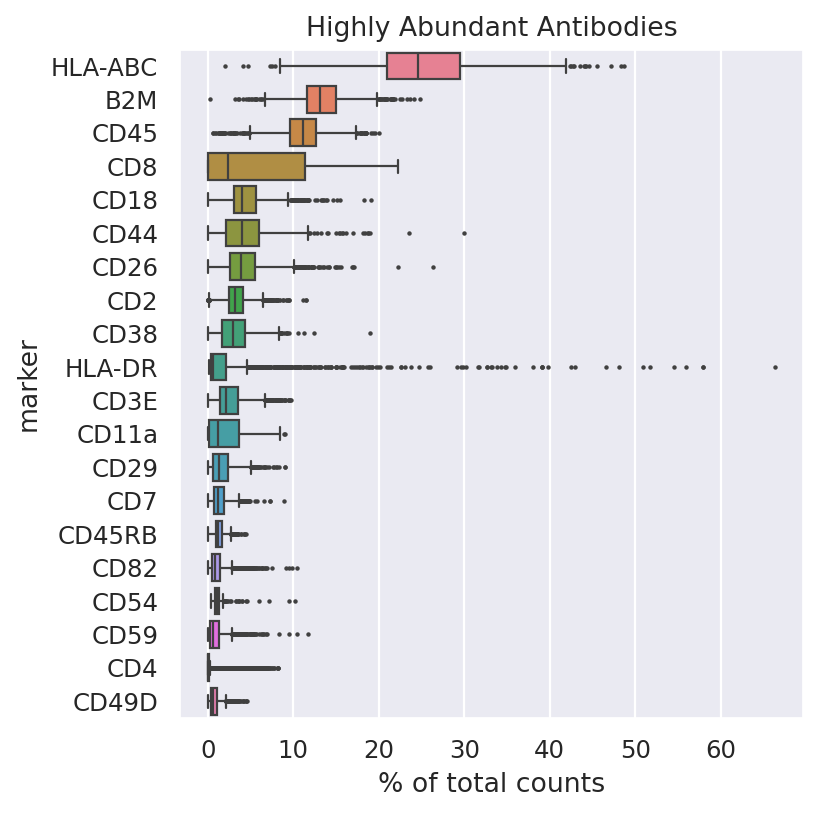

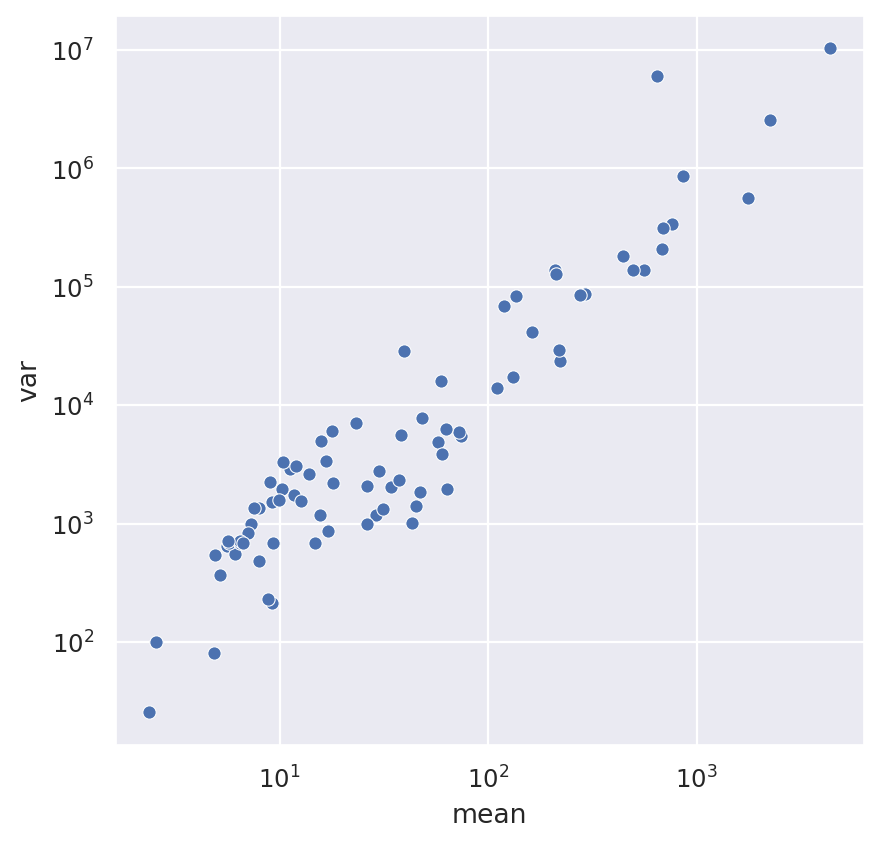

In [9]:
ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
ax.set_title('Highly Abundant Antibodies')
stats = adata.to_df().agg(['mean', 'var',], axis=0).T
fig, ax = plt.subplots(1)
sns.scatterplot(x=stats['mean'], y=stats['var'], ax=ax)
ax.loglog()
# var_genes = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=20, batch_key='sample', layer='counts', inplace=False)
# sc.pl.highly_variable_genes(var_genes, show=True, log=True)

In [10]:
components = adata.obs[adata.obs['sample'].isin(['imm_rantes', 'sol_rantes'])].index
adata = adata[components, :]

In [11]:
adata.layers['dsb'] = dsb_normalize(adata.to_df('counts'), isotype_controls=['mIgG1', 'mIgG2a', 'mIgG2b'])
adata.layers['clr_by_cell'] = clr_transformation(adata.to_df('counts'), axis=1)
adata.layers['clr_by_ab'] = clr_transformation(adata.to_df('counts'), axis=0)
adata.layers['log1p'] = np.log1p(adata.to_df('counts'))

/tmp/ipykernel_1159976/2096427258.py:1: ImplicitModificationWarning: Setting element `.layers['dsb']` of view, initializing view as actual.
  adata.layers['dsb'] = dsb_normalize(adata.to_df('counts'), isotype_controls=['mIgG1', 'mIgG2a', 'mIgG2b'])


<Axes: title={'center': 'Cumulative Variance Explained'}>

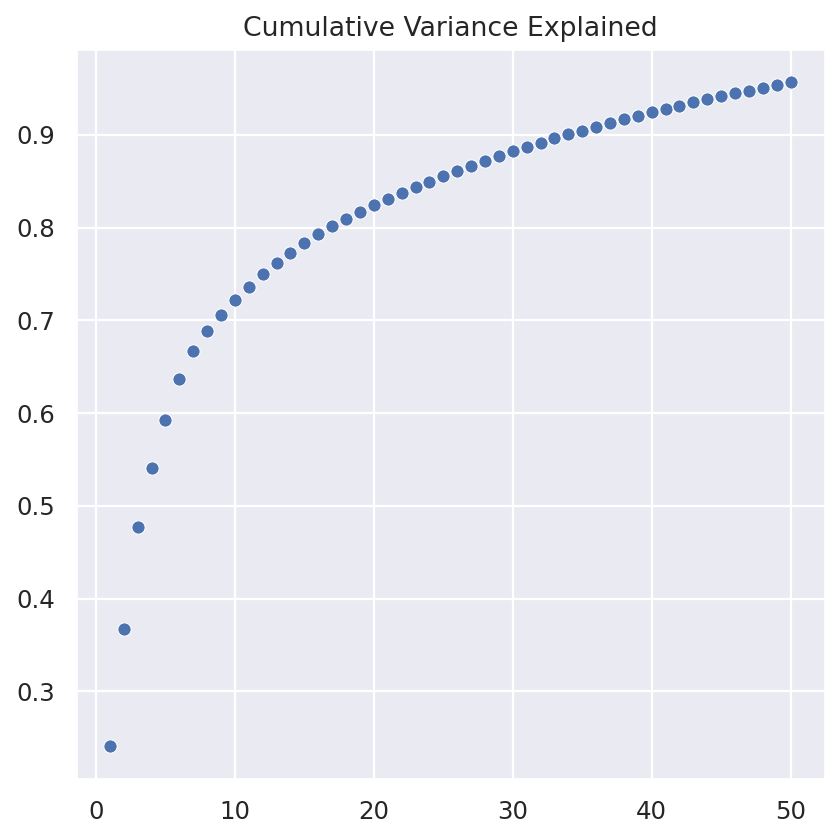

In [12]:
sc.tl.pca(adata, layer='dsb')
plot_cumulative_variance(adata)

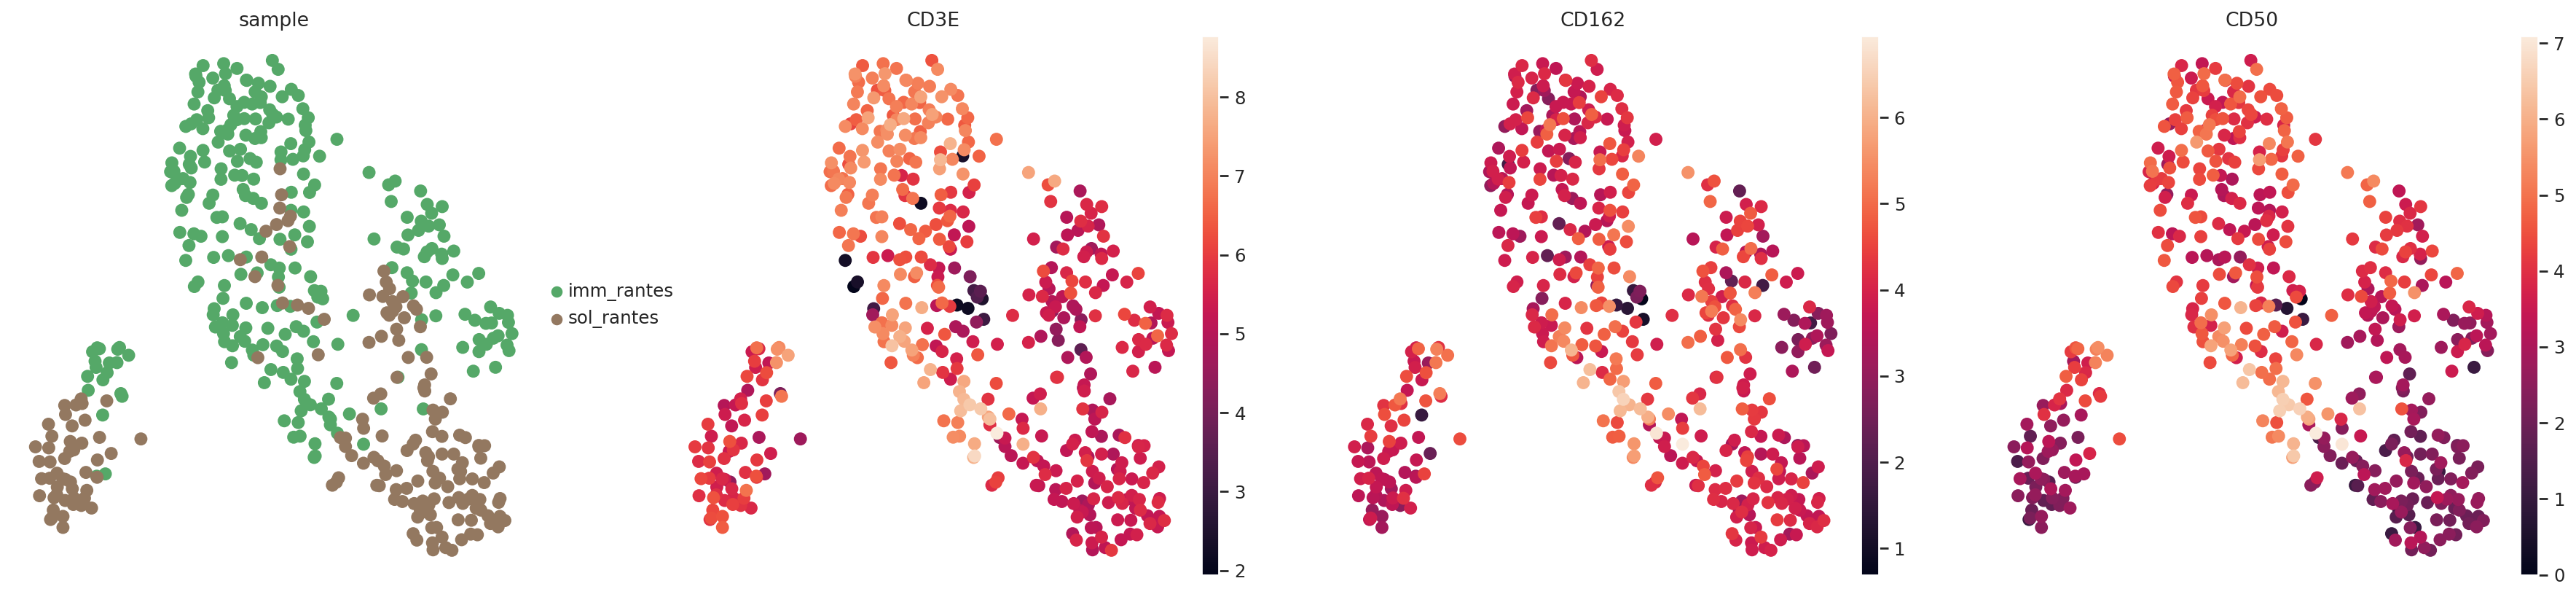

In [13]:
sc.pp.neighbors(adata,)
sc.tl.umap(adata, )
sc.pl.umap(adata, layer='log1p', color=['sample', 'CD3E', 'CD162', 'CD50'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: 80.476. Signaling Trainer to stop.


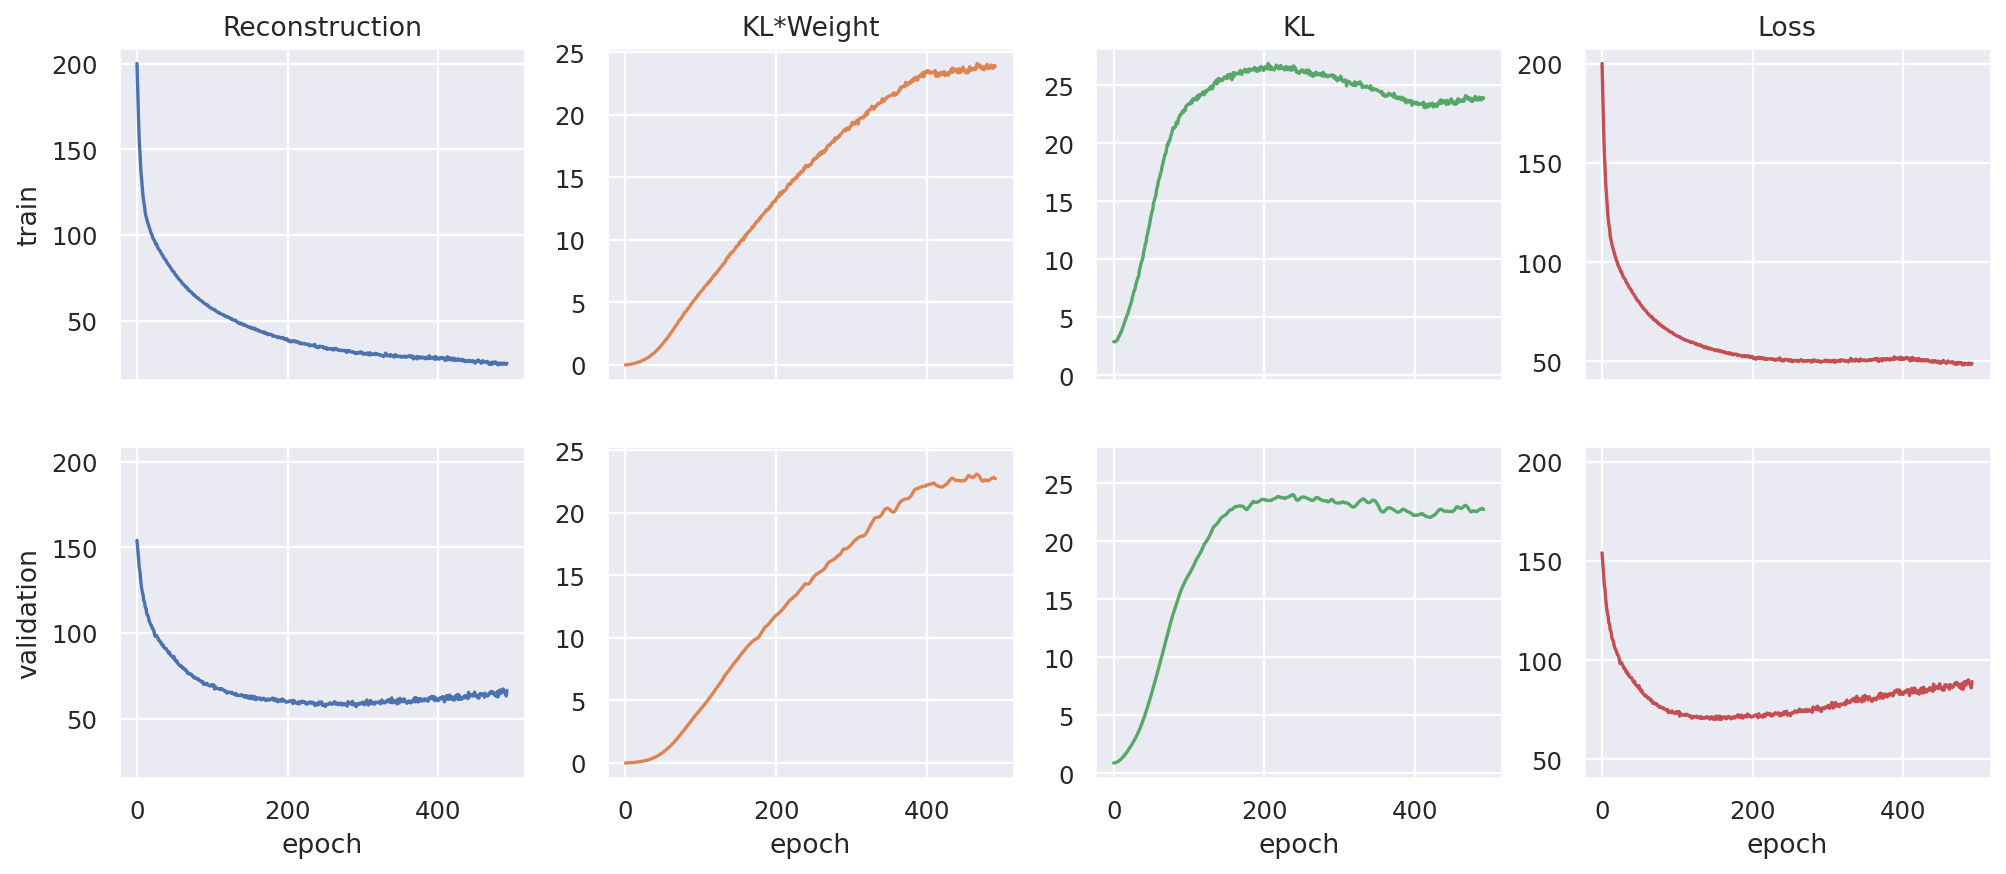

In [17]:
EPOCHS = 10000
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=2000, n_epochs_kl_warmup=400, lr=1e-3,
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(optimizer='Adam'))
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1, prior_mixture=False)
model_cls = CytoVI
model_cls.setup_anndata(adata, layer='dsb', batch_key='sample',)
model = model_cls(adata, **model_kwargs)
model.train(**train_kwargs)
ax = plot_losses(model,)

In [18]:
polarization = convert_polarization_to_feature_matrix(pg_data.polarization, components=adata.obs.index, key='morans_i', fill_na_with_mean=True)
# polarization = np.log1p(polarization)
adata.obsm['polarization_morans_i'] = polarization.reindex(adata.obs.index)
polarization = adata.obsm['polarization_morans_i']
adata.obs['CD162_pol'] = adata.obsm['polarization_morans_i']['CD162_pol']
adata.obsm['polarization_morans_i']

ACTB_pol   B2M_pol  CD102_pol  CD11a_pol  CD11b_pol  \
component                                                                       
RCVCMP0000012_imm_rantes  0.041592 -0.015353  -0.003729  -0.006783   0.013447   
RCVCMP0000013_imm_rantes  0.031865  0.088864   0.012725   0.028231   0.004943   
RCVCMP0000018_imm_rantes  0.018778  0.106305  -0.011280  -0.010683   0.013447   
RCVCMP0000020_imm_rantes  0.084649  0.193289   0.011483  -0.002505   0.027488   
RCVCMP0000021_imm_rantes  0.212704  0.128088   0.033653   0.114082   0.082606   
...                            ...       ...        ...        ...        ...   
RCVCMP0000511_sol_rantes  0.041592 -0.006234   0.007111  -0.001005   0.013447   
RCVCMP0000536_sol_rantes  0.041592 -0.001259   0.006264   0.012733   0.013447   
RCVCMP0000547_sol_rantes  0.041592  0.004280   0.001613  -0.016979   0.013447   
RCVCMP0000692_sol_rantes  0.041592  0.017079  -0.007959  -0.010711  -0.005328   
RCVCMP0000752_sol_rantes  0.041592  0.006885  -0.006953  -0.005135   0.013447   

                          CD11c_pol  CD127_pol  CD137_pol  CD14_pol  \
component                                                             
RCVCMP0000012_imm_rantes  -0.009634   0.004143   0.030859  0.048798   
RCVCMP0000013_imm_rantes   0.016342   0.008538   0.014973  0.041452   
RCVCMP0000018_imm_rantes   0.097657   0.116950   0.030859  0.149549   
RCVCMP0000020_imm_rantes   0.020582   0.023251   0.037301  0.035482   
RCVCMP0000021_imm_rantes   0.132631   0.150013   0.030859  0.139659   
...                             ...        ...        ...       ...   
RCVCMP0000511_sol_rantes   0.008031  -0.015191   0.030859  0.048798   
RCVCMP0000536_sol_rantes   0.008031  -0.001774   0.030859  0.048798   
RCVCMP0000547_sol_rantes   0.008031  -0.007220   0.030859  0.048798   
RCVCMP0000692_sol_rantes   0.008031  -0.004633   0.030859  0.048798   
RCVCMP0000752_sol_rantes   0.008031  -0.002951   0.030859  0.048798   

                          CD150_pol  ...  CD82_pol  CD84_pol  CD86_pol  \
component                            ...                                 
RCVCMP0000012_imm_rantes  -0.000451  ...  0.008261  0.007894 -0.003623   
RCVCMP0000013_imm_rantes   0.007539  ...  0.048534  0.003433  0.054577   
RCVCMP0000018_imm_rantes   0.020461  ...  0.032200  0.008348  0.001210   
RCVCMP0000020_imm_rantes   0.028799  ...  0.001438  0.015594 -0.002651   
RCVCMP0000021_imm_rantes   0.145829  ...  0.060347  0.240261  0.019910   
...                             ...  ...       ...       ...       ...   
RCVCMP0000511_sol_rantes   0.020461  ... -0.000444 -0.002203  0.002615   
RCVCMP0000536_sol_rantes   0.020461  ...  0.006992  0.027112  0.003794   
RCVCMP0000547_sol_rantes   0.020461  ... -0.004580  0.002366  0.005904   
RCVCMP0000692_sol_rantes   0.020461  ...  0.000925  0.000770 -0.003730   
RCVCMP0000752_sol_rantes   0.020461  ...  0.012991  0.002366 -0.009874   

                           CD9_pol  HLA-ABC_pol  HLA-DR_pol  TCRVb5_pol  \
component                                                                 
RCVCMP0000012_imm_rantes  0.030321    -0.029365   -0.017168   -0.009841   
RCVCMP0000013_imm_rantes  0.023241     0.112942    0.189797    0.002530   
RCVCMP0000018_imm_rantes  0.030321     0.085089    0.062718    0.087174   
RCVCMP0000020_imm_rantes  0.055438     0.359677    0.037842    0.005275   
RCVCMP0000021_imm_rantes  0.123492     0.174178    0.063315    0.330841   
...                            ...          ...         ...         ...   
RCVCMP0000511_sol_rantes  0.030321    -0.004344    0.011635    0.004638   
RCVCMP0000536_sol_rantes -0.006139    -0.017669    0.015095    0.004638   
RCVCMP0000547_sol_rantes  0.030321    -0.010732    0.000795   -0.005605   
RCVCMP0000692_sol_rantes  0.030321     0.023587   -0.004541   -0.001054   
RCVCMP0000752_sol_rantes  0.030321     0.010875    0.030408   -0.006992   

                          mIgG1_pol  mIgG2a_pol  mIgG2b_pol  
component                                      

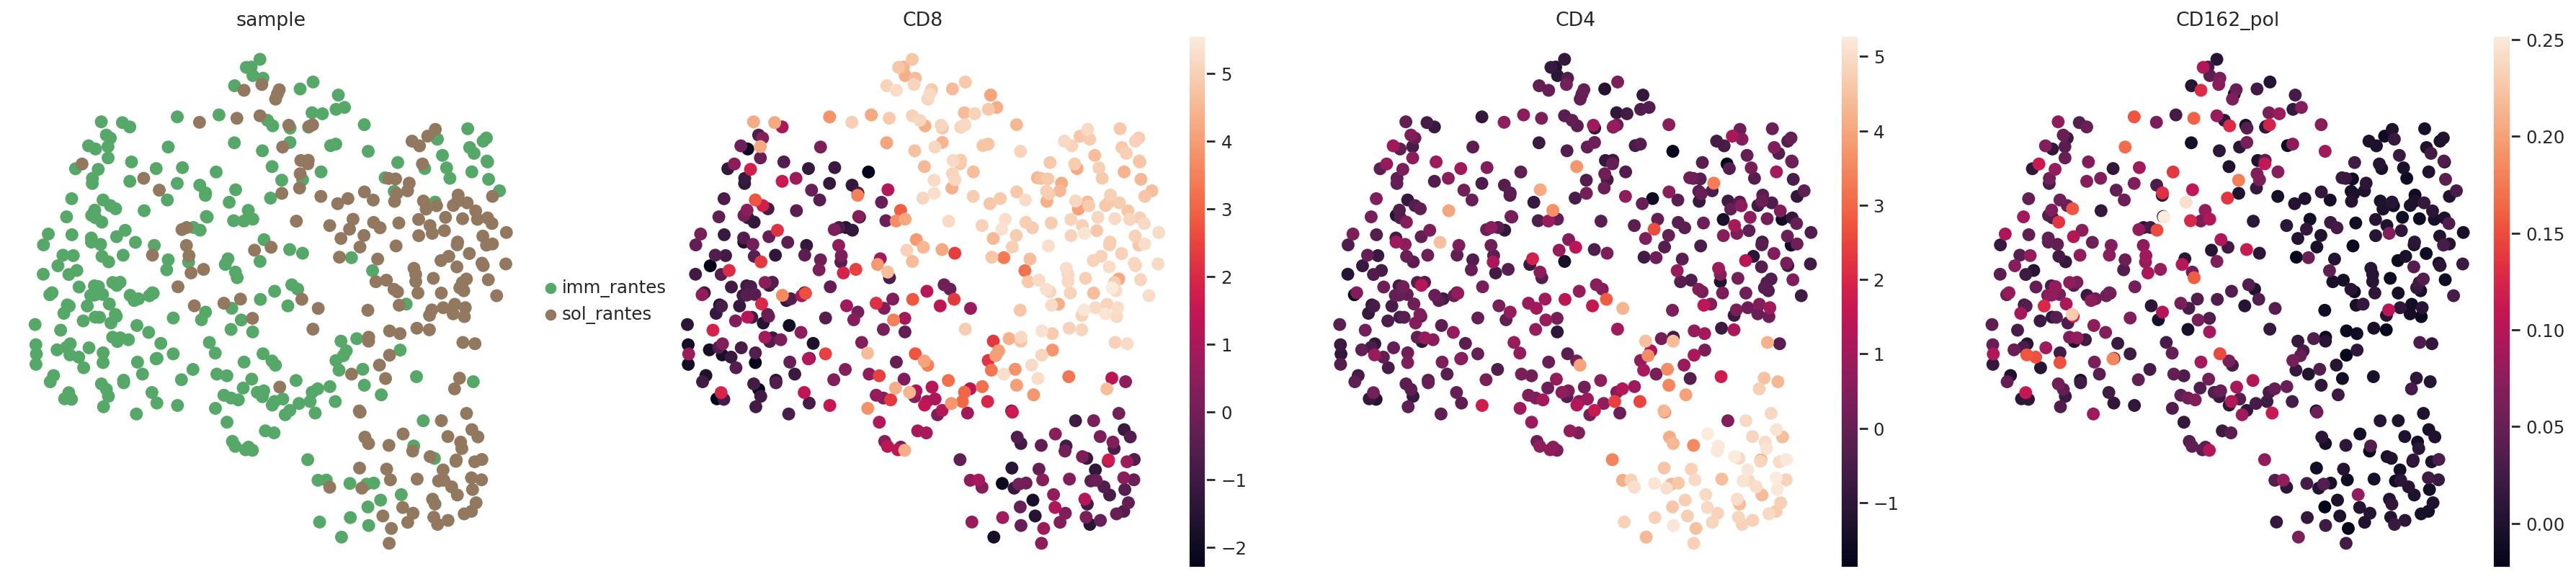

In [19]:
adata.obsm['model_latent'] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='model_latent', key_added='model_latent')
sc.tl.umap(adata, neighbors_key='model_latent')
sc.pl.umap(adata, layer='dsb', color=['sample', 'CD8', 'CD4', 'CD162_pol'])

In [20]:
joint_df = pd.concat((adata.to_df('dsb'), polarization), axis=1)
# joint_df = center_feature_matrix(joint_df) 
joint_adata = anndata.AnnData(
    X=joint_df,
    obs=adata.obs
)
pol_adata = anndata.AnnData(
    X=polarization,
    obs=adata.obs
)
joint_adata.to_df()

B2M     CD102     CD11a     CD11b     CD11c  \
component                                                                    
RCVCMP0000012_imm_rantes  0.217435 -0.023725 -1.091946  0.436238  0.641175   
RCVCMP0000013_imm_rantes  1.322622  2.098635  2.224566 -0.063806  0.475942   
RCVCMP0000018_imm_rantes  0.280743 -0.388274  0.158085  0.912124  0.744083   
RCVCMP0000020_imm_rantes  0.185710  0.551910  1.919032  1.147919  0.915591   
RCVCMP0000021_imm_rantes  0.193985 -0.070187  0.700470  0.887372  1.206676   
...                            ...       ...       ...       ...       ...   
RCVCMP0000511_sol_rantes  0.010078  0.721854  2.792248  0.375776 -0.309205   
RCVCMP0000536_sol_rantes  0.092828  0.572489  2.981829 -0.746559  0.230919   
RCVCMP0000547_sol_rantes  0.182790  0.334625  3.469486  0.630735  0.607404   
RCVCMP0000692_sol_rantes  0.029268  0.915535  3.230235  1.505874  0.411538   
RCVCMP0000752_sol_rantes  0.253782  0.951893  2.868074  0.880638  0.694203   

                             CD127     CD137      CD14     CD150     CD152  \
component                                                                    
RCVCMP0000012_imm_rantes  0.397161  0.218168  0.625346  1.389450  0.966076   
RCVCMP0000013_imm_rantes  1.309431 -0.095579 -0.143379 -0.167313  0.378149   
RCVCMP0000018_imm_rantes  0.914994  1.095528  1.829137  0.651945  0.714511   
RCVCMP0000020_imm_rantes  2.087785  1.312298  1.262899  0.471278  0.457130   
RCVCMP0000021_imm_rantes  0.321251  0.003316  1.342488  0.688384  1.863046   
...                            ...       ...       ...       ...       ...   
RCVCMP0000511_sol_rantes  1.879095  0.602572  1.108908  0.911159 -0.362726   
RCVCMP0000536_sol_rantes  2.113833 -0.568778 -0.185795 -0.326864 -0.711840   
RCVCMP0000547_sol_rantes  2.685848  0.886648  0.773116  1.234843  0.943278   
RCVCMP0000692_sol_rantes  2.392861 -0.055495  1.558503 -0.435163 -0.337115   
RCVCMP0000752_sol_rantes  2.458093  1.118785  0.555077 -0.348946 -0.281873   

                          ...  CD82_pol  CD84_pol  CD86_pol   CD9_pol  \
component                 ...                                           
RCVCMP0000012_imm_rantes  ...  0.008261  0.007894 -0.003623  0.030321   
RCVCMP0000013_imm_rantes  ...  0.048534  0.003433  0.054577  0.023241   
RCVCMP0000018_imm_rantes  ...  0.032200  0.008348  0.001210  0.030321   
RCVCMP0000020_imm_rantes  ...  0.001438  0.015594 -0.002651  0.055438   
RCVCMP0000021_imm_rantes  ...  0.060347  0.240261  0.019910  0.123492   
...                       ...       ...       ...       ...       ...   
RCVCMP0000511_sol_rantes  ... -0.000444 -0.002203  0.002615  0.030321   
RCVCMP0000536_sol_rantes  ...  0.006992  0.027112  0.003794 -0.006139   
RCVCMP0000547_sol_rantes  ... -0.004580  0.002366  0.005904  0.030321   
RCVCMP0000692_sol_rantes  ...  0.000925  0.000770 -0.003730  0.030321   
RCVCMP0000752_sol_rantes  ...  0.012991  0.002366 -0.009874  0.030321   

                          HLA-ABC_pol  HLA-DR_pol  TCRVb5_pol  mIgG1_pol  \
component                                                                  
RCVCMP0000012_imm_rantes    -0.029365   -0.017168   -0.009841   0.006880   
RCVCMP0000013_imm_rantes     0.112942    0.189797    0.002530   0.002693   
RCVCMP0000018_imm_rantes     0.085089    0.062718    0.087174   0.006880   
RCVCMP0000020_imm_rantes     0.359677    0.037842    0.005275   0.012067   
RCVCMP0000021_imm_rantes     0.174178    0.063315    0.330841   0.101395   
...                               ...         ...         ...        ...   
RCVCMP0000511_sol_rantes    -0.004344    0.011635    0.004638   0.006880   
RCVCMP0000536_sol_rantes    -0.017669    0.015095    0.004638   0.006880   
RCVCMP0000547_sol_rantes    -0.010732    0.000795   -0.005605   0.006880   
RCVCMP0000692_sol_rantes     0.023587   -0.004541   -0.001054   0.006880   
RCVCMP0000752_sol_rantes     0.010875    0.030408   -0.006992   0.006880   

                          mIgG2a_pol  mIgG2b_pol  
component  

In [ ]:
scvi.model.MULTIVI

INFO     Using column names from columns of adata.obsm['polarization_morans_i']                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: -89.230. Signaling Trainer to stop.


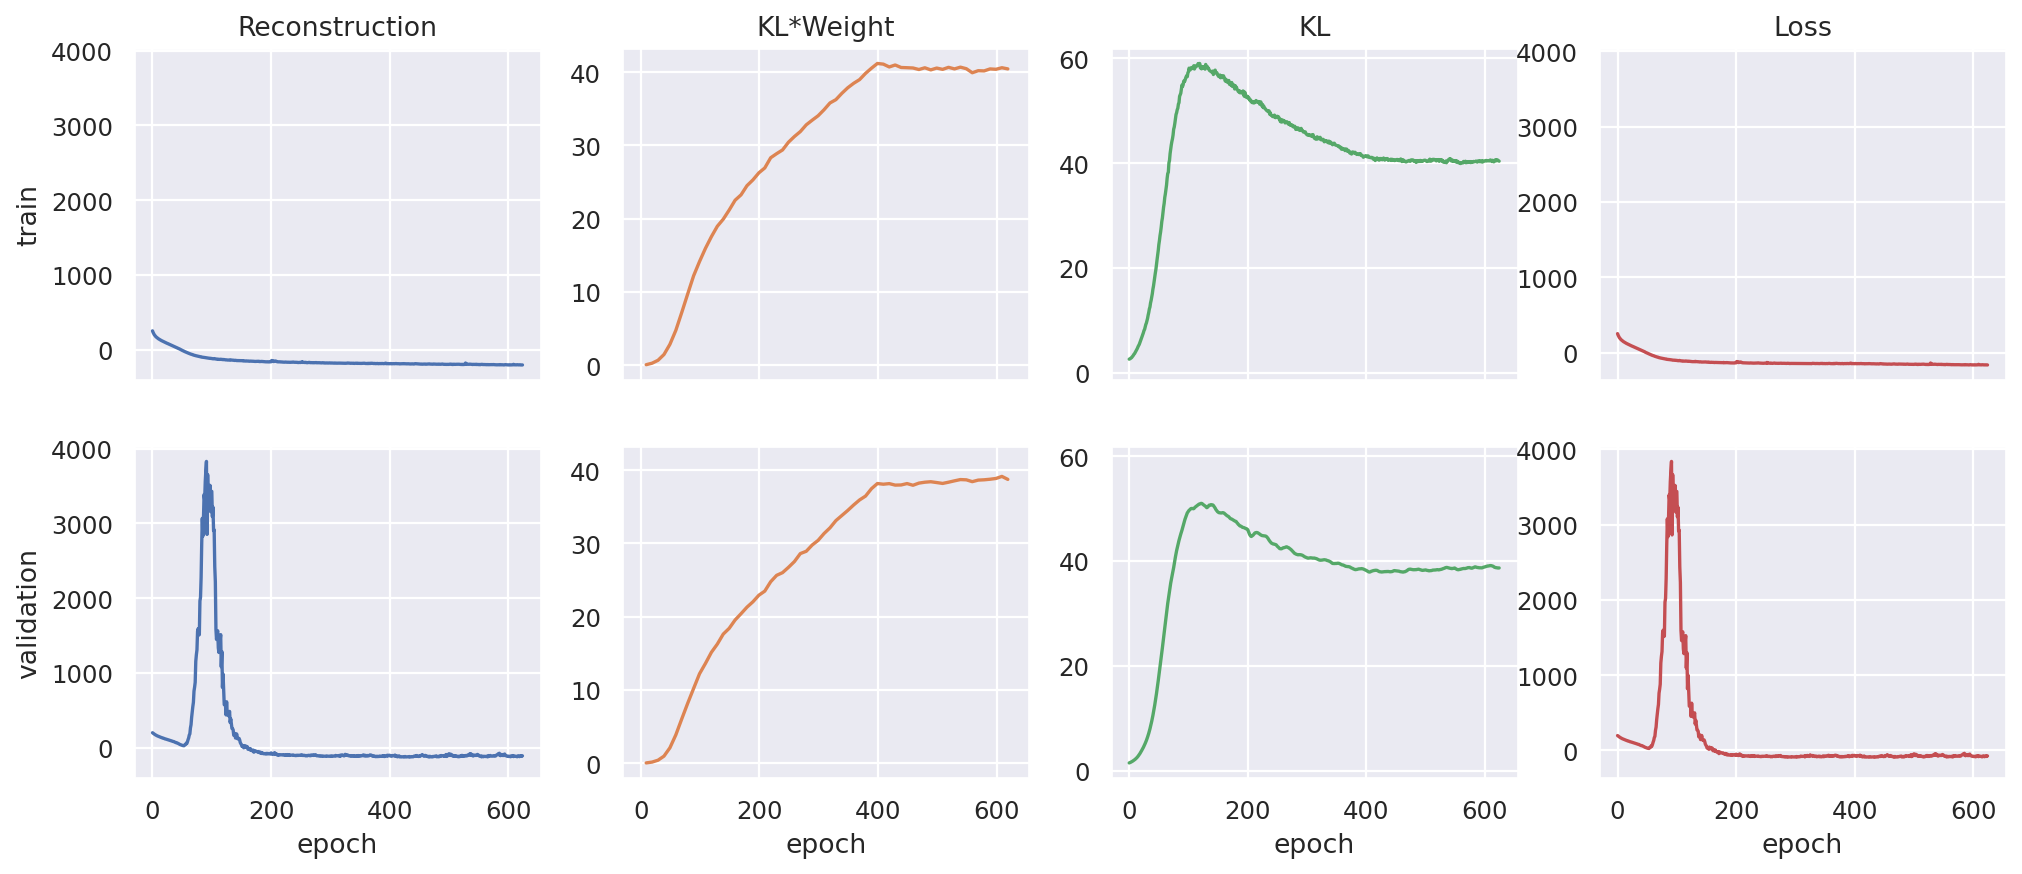

In [36]:
EPOCHS = 10000

obsm_extra_modality_keys=['polarization_morans_i']

model_cls = NormalSCVI
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=1000, 
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(optimizer='Adam', n_epochs_kl_warmup=400, lr=1e-3,))
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1, n_extra_modalities=1, obsm_extra_modality_keys=obsm_extra_modality_keys, weights=[0.9, 0.1])
model_cls.setup_anndata(adata, layer='dsb', batch_key='sample', obsm_extra_modality_keys=obsm_extra_modality_keys)
multi_model = model_cls(adata, **model_kwargs)
# print(normal_joint_model)
multi_model.train(**train_kwargs)
ax = plot_losses(multi_model)

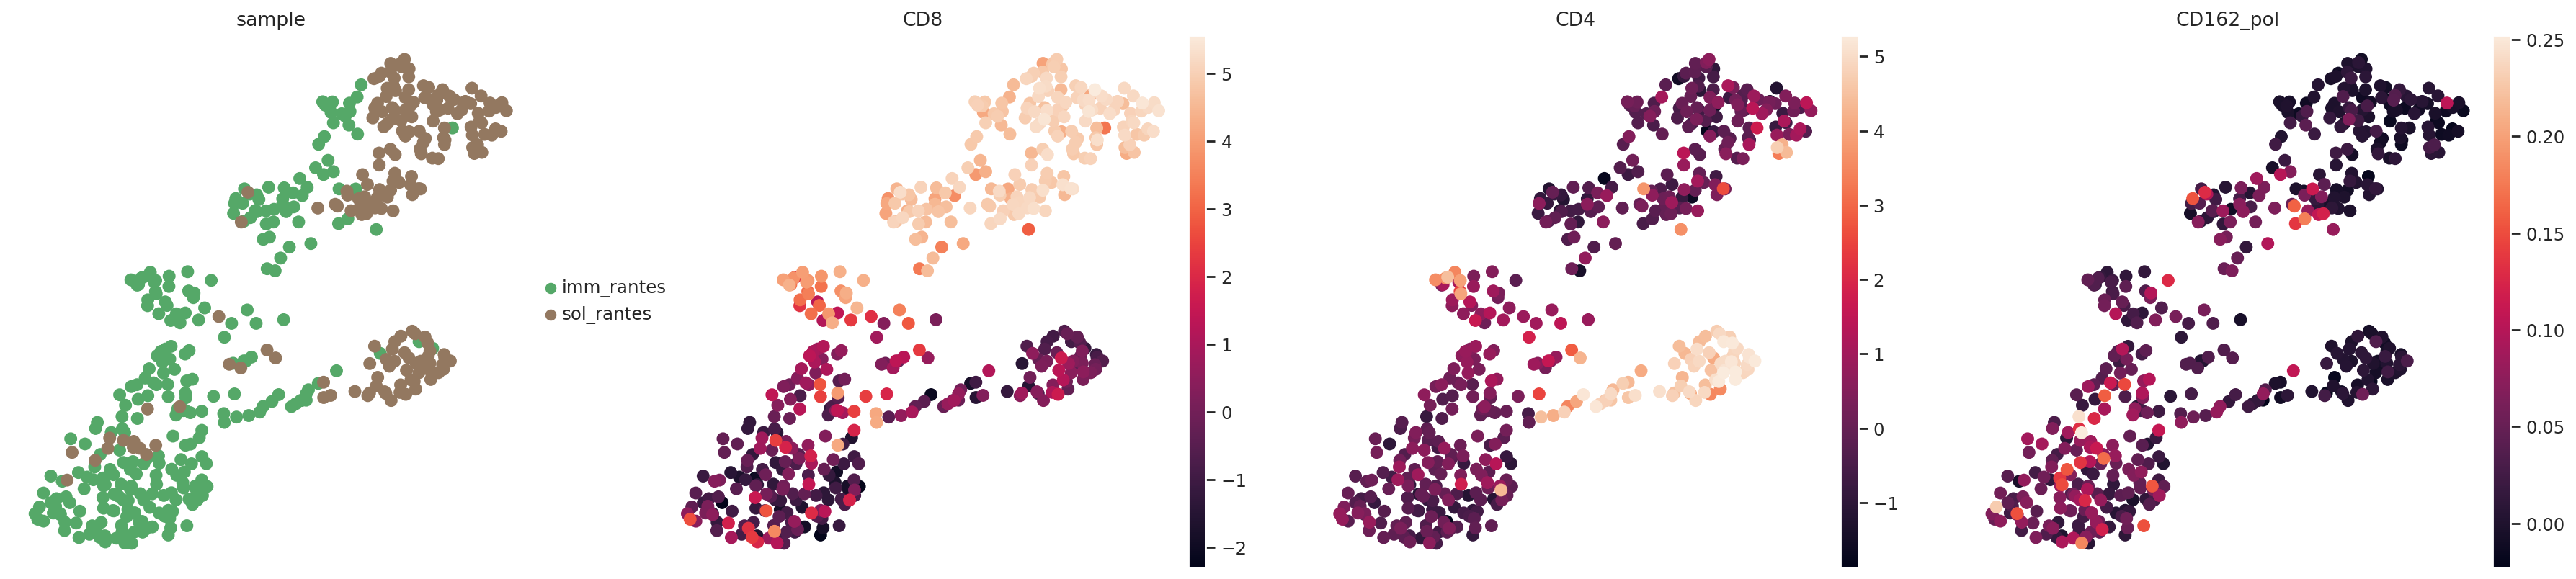

In [37]:
adata.obsm['multi_model_latent'] = multi_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='multi_model_latent', key_added='multi_model_latent')
sc.tl.umap(adata, neighbors_key='multi_model_latent')
sc.pl.umap(adata, layer='dsb', color=['sample', 'CD8', 'CD4', 'CD162_pol'])

Normal SCVI Model with the following params: 
n_latent: 20
n_extra_modalities: 0
weights: tensor([1.], dtype=torch.float64)
input_ds: [160]
Training status: Not Trained

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 200 records. Best score: -100.866. Signaling Trainer to stop.


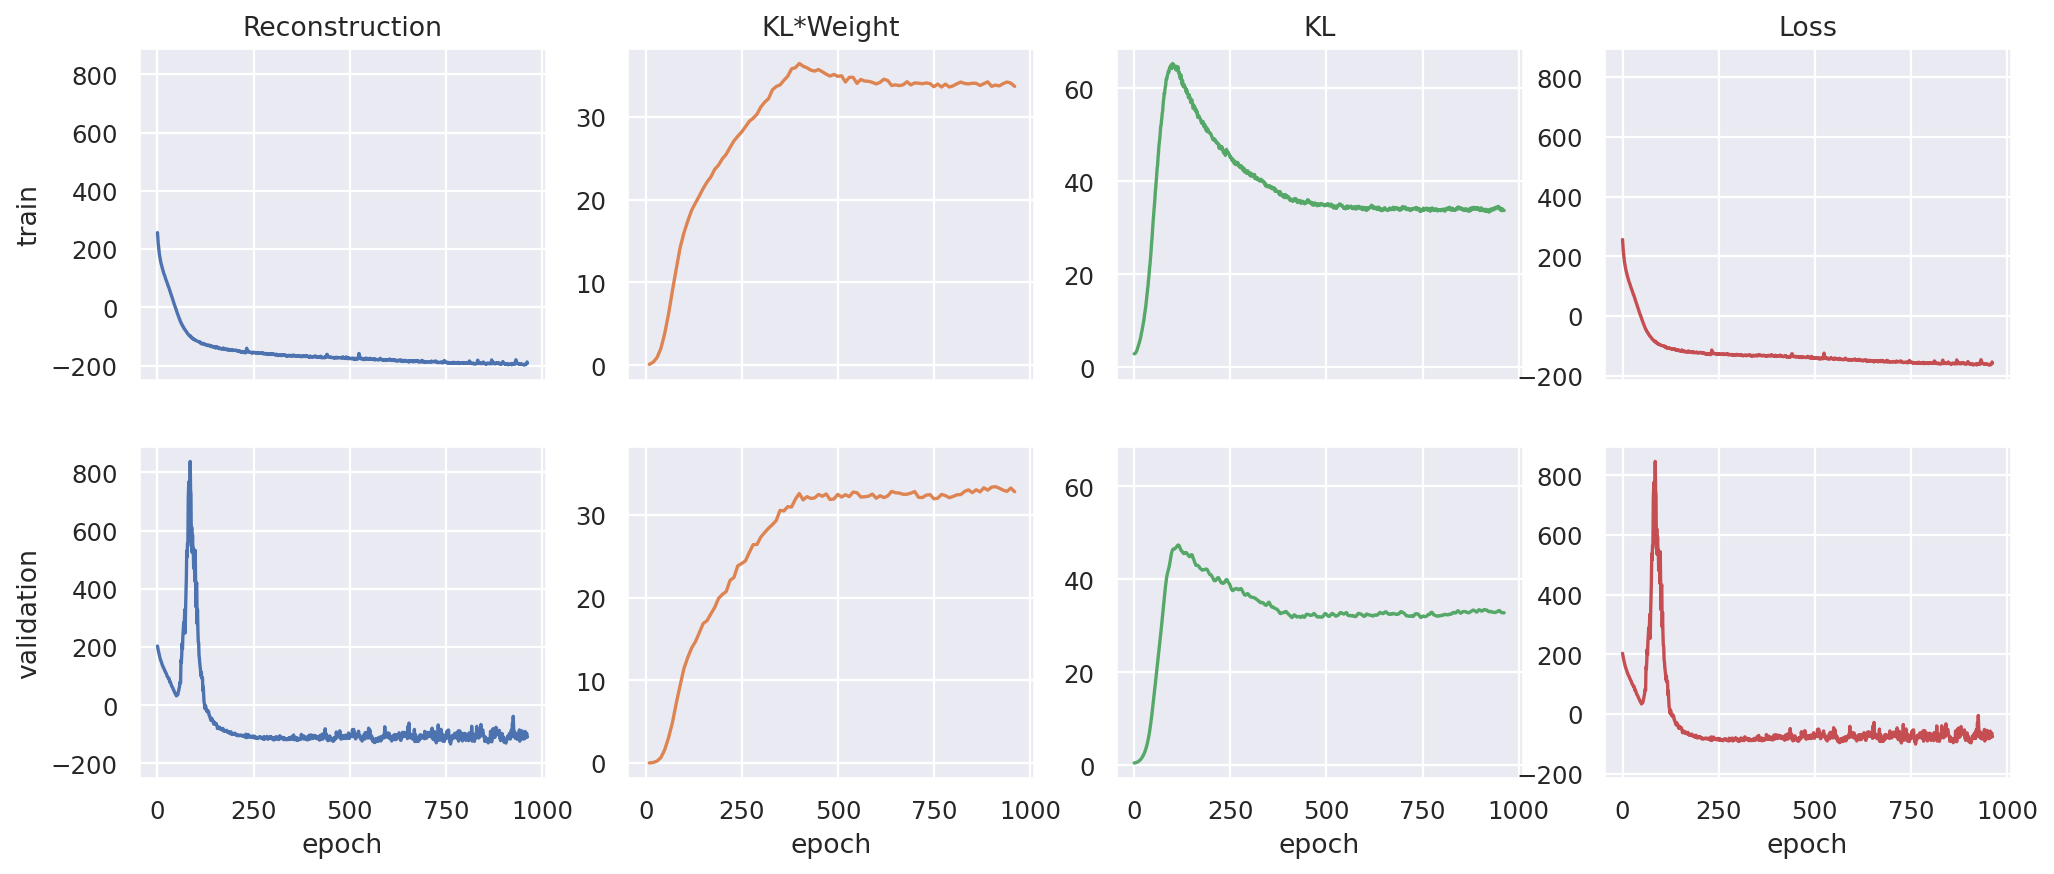

In [185]:
EPOCHS = 10000

# model_cls = CytoVI
# train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=1000, n_epochs_kl_warmup=400, lr=1e-3,
#                     max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(optimizer='Adam'))
# model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1, prior_mixture=False)
# model_cls.setup_anndata(joint_adata, batch_key='sample',)
# cyto_joint_model = model_cls(joint_adata, **model_kwargs)
# cyto_joint_model.train(**train_kwargs)
# ax = plot_losses(cyto_joint_model)


model_cls = NormalSCVI
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=200, batch_size=1000, 
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(optimizer='Adam', n_epochs_kl_warmup=400, lr=1e-3,))
model_kwargs = dict(n_latent=20, n_hidden=128, n_layers=1, dropout_rate=0.1)
model_cls.setup_anndata(joint_adata, batch_key='sample',)
normal_joint_model = model_cls(joint_adata, **model_kwargs)
print(normal_joint_model)
normal_joint_model.train(**train_kwargs)
ax = plot_losses(normal_joint_model)

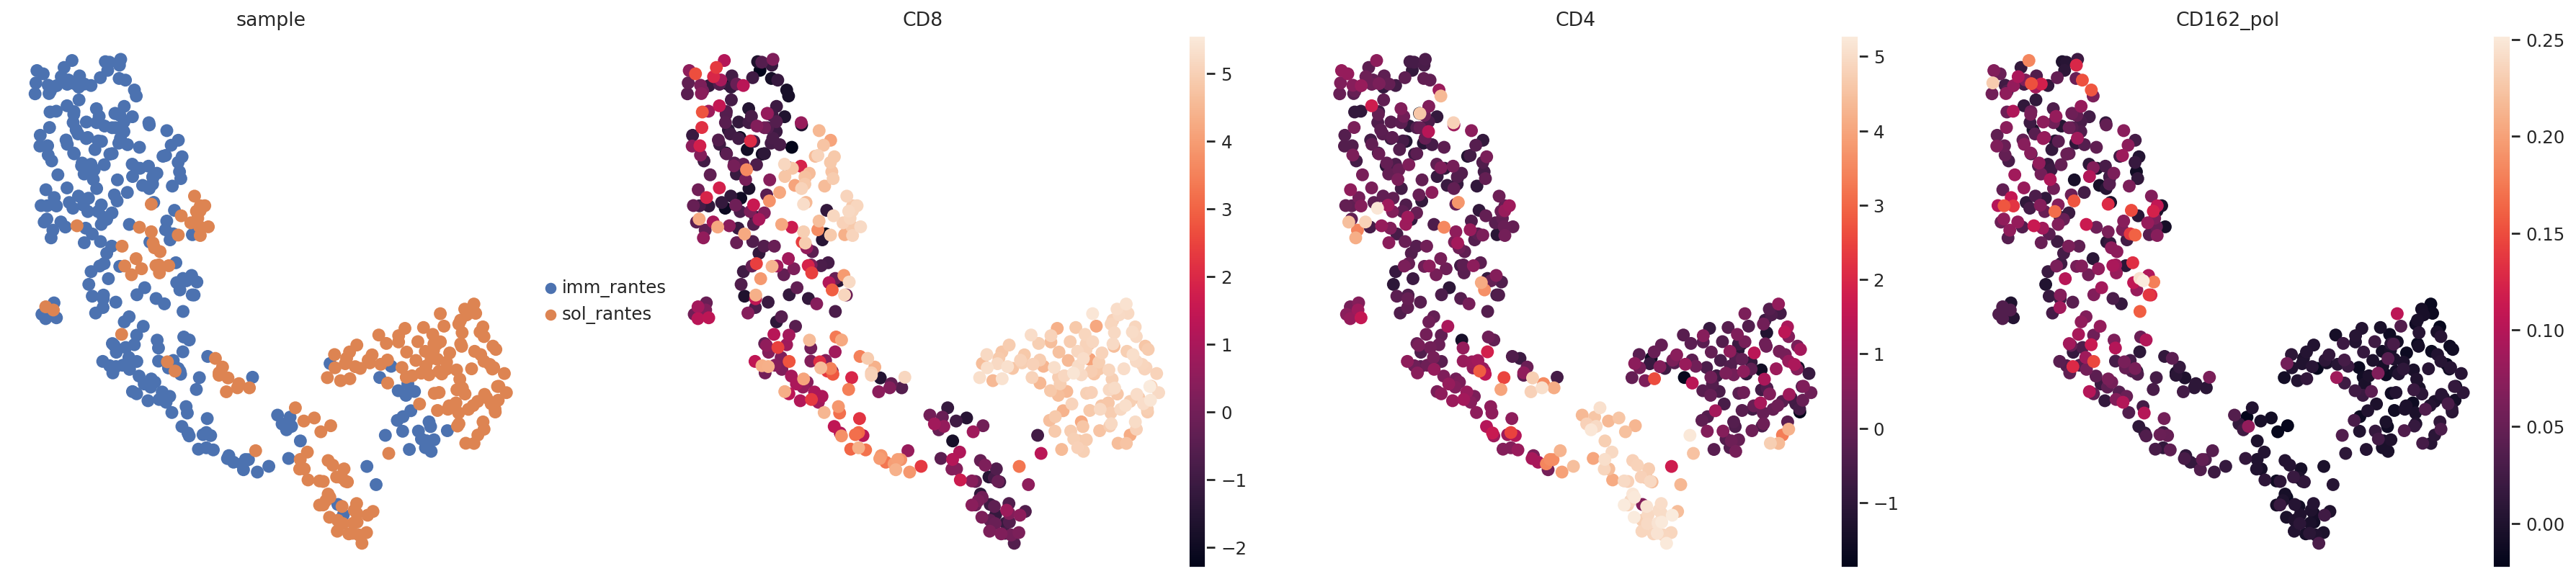

In [186]:
# joint_adata.obsm['cyto_model_latent'] = cyto_joint_model.get_latent_representation()
# sc.pp.neighbors(joint_adata, use_rep='cyto_model_latent', key_added='cyto_model_latent')
# sc.tl.umap(joint_adata, neighbors_key='cyto_model_latent')
# # joint_adata.obs.drop(columns='CD162_pol', inplace=True)
# sc.pl.umap(joint_adata, color=['sample', 'CD8', 'CD4', 'CD162_pol'])

joint_adata.obsm['normal_model_latent'] = normal_joint_model.get_latent_representation()
sc.pp.neighbors(joint_adata, use_rep='normal_model_latent', key_added='normal_model_latent')
sc.tl.umap(joint_adata, neighbors_key='normal_model_latent')
# joint_adata.obs.drop(columns='CD162_pol', inplace=True)
sc.pl.umap(joint_adata, color=['sample', 'CD8', 'CD4', 'CD162_pol'])

## Latent space concatenation

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 20 records. Best score: -164.997. Signaling Trainer to stop.


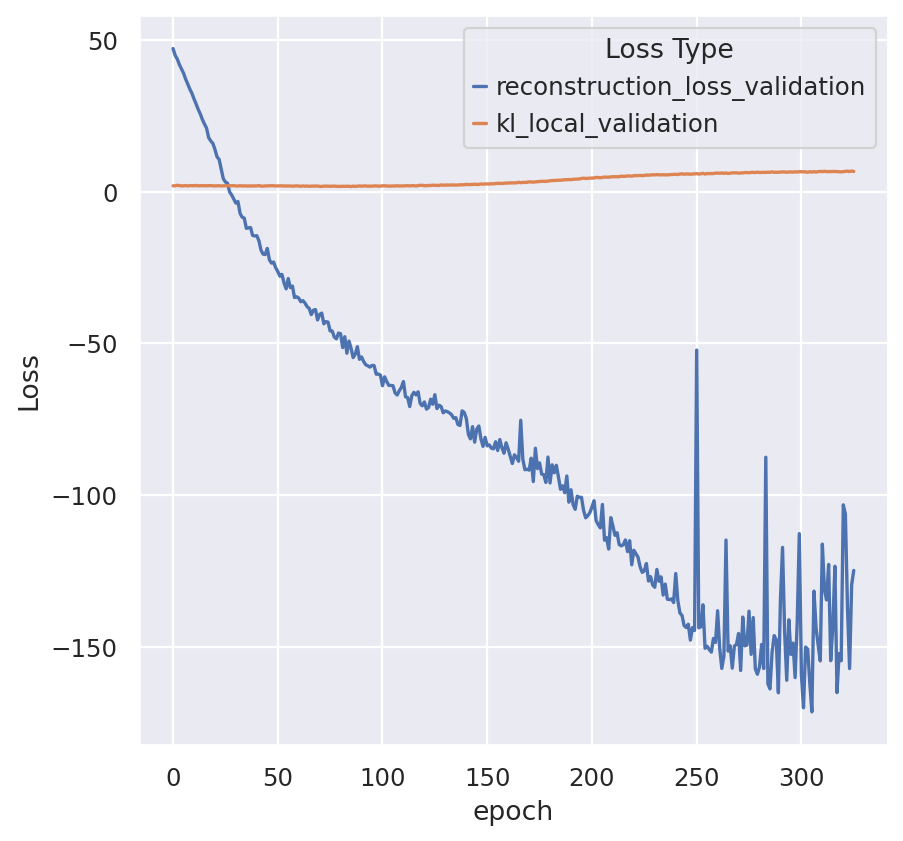

In [19]:
EPOCHS = 10000
train_kwargs = dict(train_size=0.8, check_val_every_n_epoch=1, early_stopping=True, early_stopping_patience=20, batch_size=1000,
                    max_epochs=EPOCHS, enable_checkpointing=True, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=0))
model_kwargs = dict(n_latent=10, n_hidden=128, n_layers=1, dropout_rate=0.1, prior_mixture=True)
model_cls.setup_anndata(pol_adata, batch_key='sample',)
pol_model = model_cls(pol_adata, **model_kwargs)
pol_model.train(**train_kwargs)
ax = plot_validation_loss(pol_model, semilogy=False)

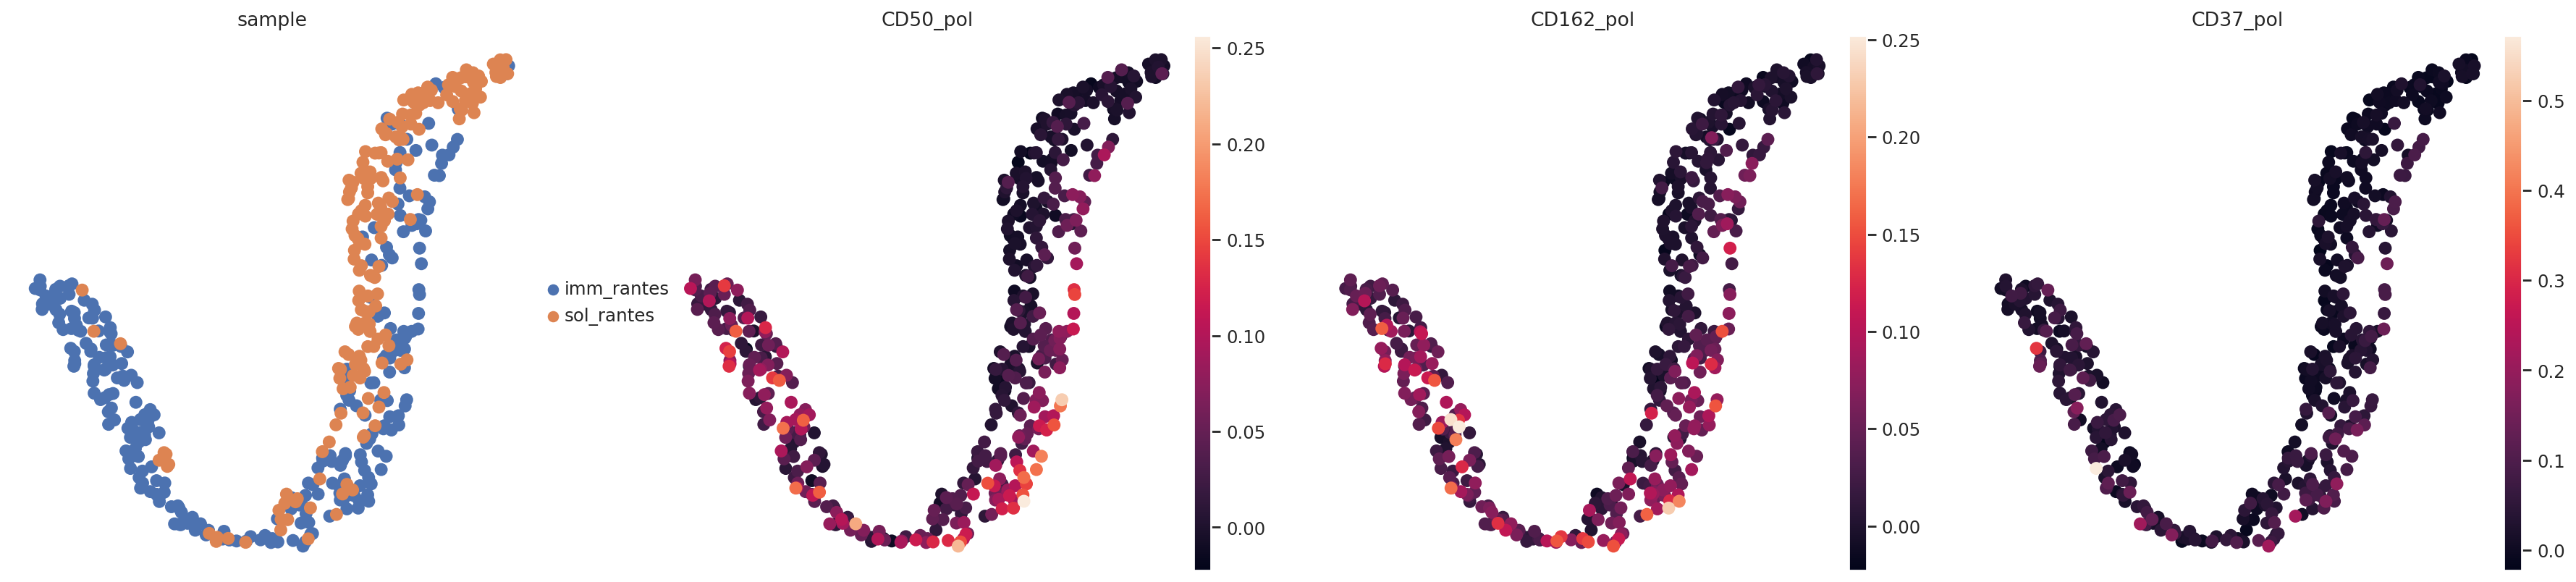

In [21]:
pol_adata.obsm['model_latent'] = pol_model.get_latent_representation()
sc.pp.neighbors(pol_adata, use_rep='model_latent', key_added='model_latent')
sc.tl.umap(pol_adata, neighbors_key='model_latent')
pol_adata.obs.drop(columns='CD162_pol', inplace=True)
sc.pl.umap(pol_adata, color=['sample', 'CD50_pol', 'CD162_pol', 'CD37_pol'])

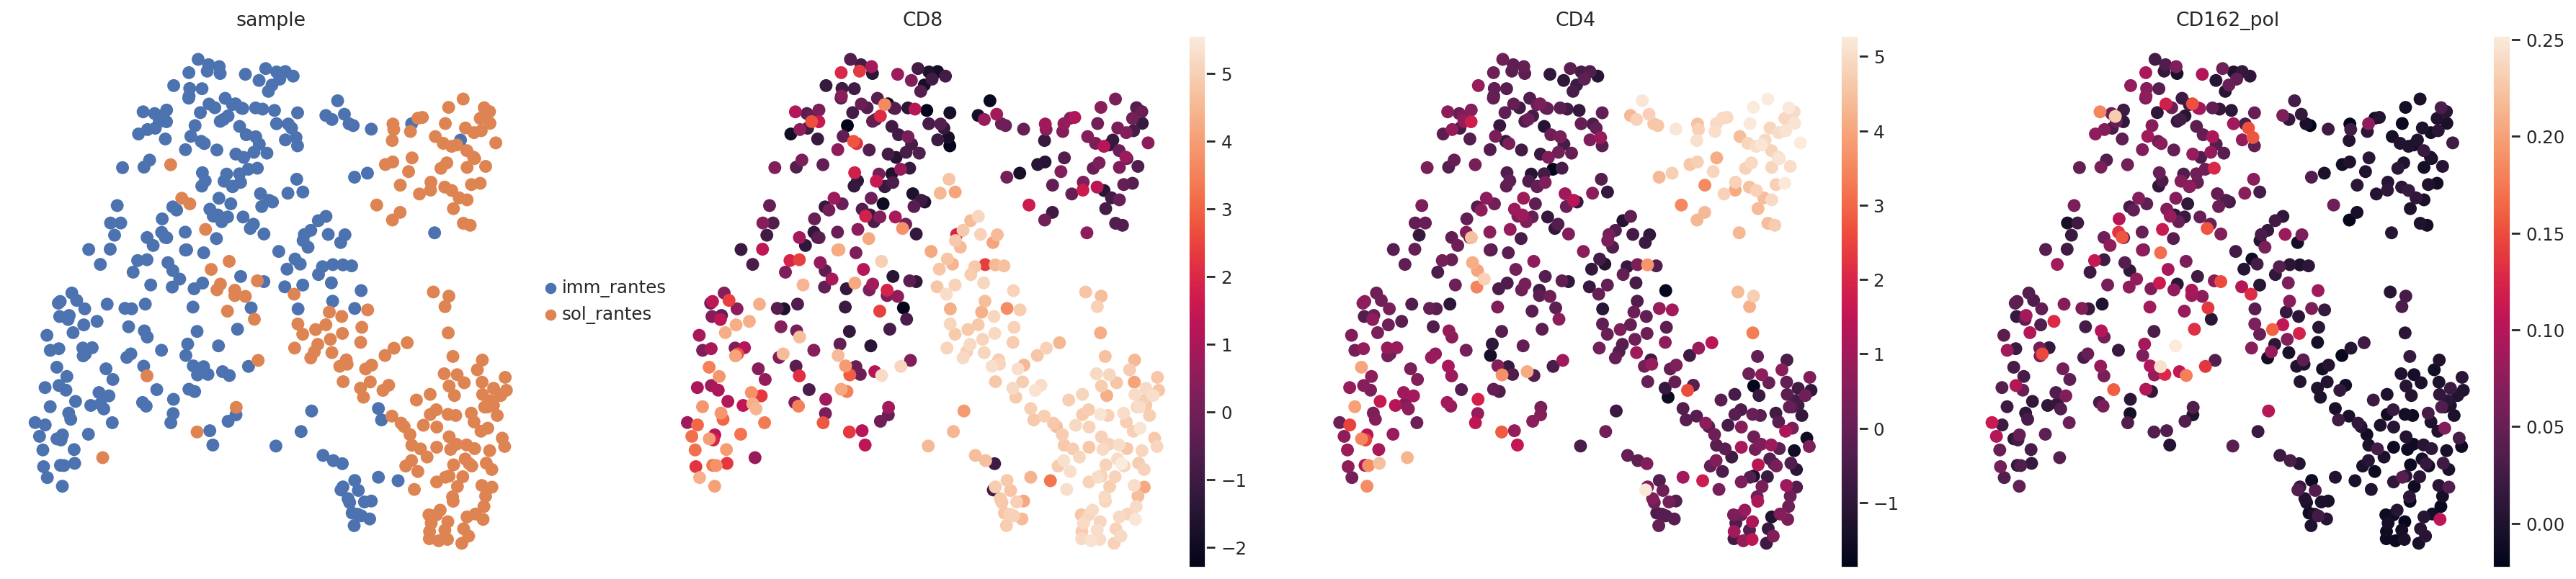

In [23]:
adata.obsm['concat_latent'] = np.concatenate((adata.obsm['model_latent'], pol_adata.obsm['model_latent']), axis=1)
sc.pp.neighbors(adata, use_rep='concat_latent', key_added='concat_latent')
sc.tl.umap(adata, neighbors_key='concat_latent')
sc.pl.umap(adata, layer='dsb', color=['sample', 'CD8', 'CD4', 'CD162_pol'])

In [211]:
joint_adata.layers['decoded'] = joint_model.get_normalized_expression()

In [212]:
sc.tl.rank_genes_groups(joint_adata, groupby='sample', layer='decoded', use_raw=False, method='wilcoxon')
joint_de = sc.get.rank_genes_groups_df(joint_adata, group='imm_rantes', pval_cutoff=0.05)
# sc.pl.rank_genes_groups_dotplot(joint_adata, n_genes=10, values_to_plot="pvals_adj", )
signficant_de = joint_de['names']
polarized_significant_markers = [m.split('_')[0] for m in signficant_de if 'pol' in m]
significant_markers = [m for m in signficant_de if 'pol' not in m]
print(len(polarized_significant_markers))
print(len(significant_markers))
print(sorted(list(set(polarized_significant_markers).intersection(set(significant_markers)))))
print(sorted(list(set(polarized_significant_markers).difference(set(significant_markers)))))


60
64
['CD102', 'CD11b', 'CD11c', 'CD127', 'CD154', 'CD16', 'CD161', 'CD162', 'CD163', 'CD18', 'CD197', 'CD20', 'CD22', 'CD244', 'CD25', 'CD26', 'CD27', 'CD274', 'CD278', 'CD32', 'CD328', 'CD36', 'CD37', 'CD4', 'CD40', 'CD45RA', 'CD47', 'CD48', 'CD49D', 'CD50', 'CD52', 'CD53', 'CD54', 'CD55', 'CD59', 'CD7', 'CD72', 'CD8', 'CD82', 'CD86', 'HLA-ABC', 'HLA-DR', 'TCRVb5', 'mIgG1', 'mIgG2a', 'mIgG2b']
['ACTB', 'B2M', 'CD14', 'CD2', 'CD200', 'CD229', 'CD279', 'CD337', 'CD35', 'CD38', 'CD41', 'CD62P', 'CD71', 'CD84']


/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [ ]:
components_to_keep = pg_data_combined_pxl_object.adata[
    (pg_data_combined_pxl_object.adata.obs["molecules"] >= 10000)
    & (pg_data_combined_pxl_object.adata.obs["tau_type"] == "normal")
].obs.index

pg_data_combined_pxl_object.filter(components=components_to_keep).save(DATA_DIR/ "combined_data_filtered.pxl", force_overwrite=True)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='sample', layer='log1p', use_raw=False, method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot="logfoldchanges", cmap='bwr',)